# Check for spatial correlations in residuals of random k-fold models

In [11]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb
import gstools as gs
from matplotlib import pyplot as plt


from model_functions import select_variables
from model_functions import train_xgb_model
from model_functions import get_model_residuals
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction

In [13]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)

# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]
#test_glaciers = [54, 703, 941, 1135, 1280, 2320, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

# Run with different random seeds
rand_seed = 25

C:\Users\kasj\AppData\Local\Temp\ipykernel_14232\17134410.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [48]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate','lat','lon']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

# Select features for training
df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y = select_variables(df_train, label_cols)

X_train, y_train = df_train_X.values, df_train_y.values

# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

In [49]:
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')
cv_grid = joblib.load('Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')

In [50]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [51]:
residuals = get_model_residuals(X_train, y_train, fitted_model, splits)

In [52]:
residuals.shape

(2809,)

In [53]:
print(X_train[0][4])
print(X_train[0][5])



68.34460666077922
17.86015112957877


## Estimate variogram of residuals


In [103]:
lon_list = []
lat_list = []
alt_list = []

for train_index, val_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_ign, X_val = X_train[train_index], X_train[val_index]
    #X_train_ign, X_val_alt = X_train[train_index], X_train[val_index]
    #X_train_ign, X_val_lon = X_train[train_index], X_train[val_index]

    X_lat = X_val[:,4]
    X_lon = X_val[:,5]
    X_alt = X_val[:,0]
    
    lat_list.extend(X_lat)
    lon_list.extend(X_lon)
    alt_list.extend(X_alt)
        
# Arrays of predictions and observations for each fold
lat_all = np.hstack([*lat_list])
lon_all = np.hstack([*lon_list])
alt_all = np.hstack([*alt_list])

In [104]:
alt_all

array([ 996. ,  988. ,  981. , ..., 1154. , 1145. , 1513.3])

In [81]:
#x = data_job['lon'].values
#y = data_job['lat'].values
#mb = data_job['balance_netto'].values
coords = np.stack((lon_all,lat_all), axis=1)

# Use only data that is not nan
#coords=coords[~np.isnan(mb)]
#mb_clean=mb[~np.isnan(mb)]

In [80]:
# estimate the variogram of the field
bin_center, gamma = gs.vario_estimate((lon_all, lat_all), residuals, latlon=True, geo_scale=gs.KM_SCALE)

print('bin_center: ', bin_center)
print('gamma: ', gamma)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

bin_center:  [ 11.46481707  34.39445122  57.32408537  80.25371952 103.18335367
 126.11298782 149.04262197 171.97225612 194.90189027 217.83152441
 240.76115856 263.69079271 286.62042686 309.55006101 332.47969516
 355.40932931 378.33896346 401.26859761 424.19823175 447.1278659
 470.05750005 492.9871342  515.91676835 538.8464025 ]
gamma:  [0.38179609 0.33532766 0.37151586 0.48654157 0.46982091 0.40008305
 0.32575189 0.40809838 0.39684302 0.34315392 0.34864048 0.41644276
 0.40233528 0.40563555 0.25891225 0.         0.         0.
 0.         0.53833652 0.17281399 0.56324893 0.24386688 0.        ]
estimated bin number: 24
maximal bin distance: 538.8464024985662


In [83]:
models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

C:\Program Files\Anaconda3\envs\ML_MB_Norway_env\lib\site-packages\gstools\covmodel\plot.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


JBessel(dim=2, var=2.17e-16, len_scale=3.03e+03, nugget=0.305, nu=50.0)


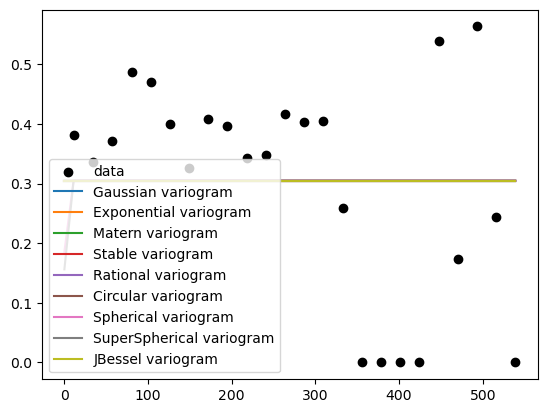

In [84]:
# plot the estimated variogram
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=max(bin_center), ax=ax)
    scores[model] = r2
print(fit_model)

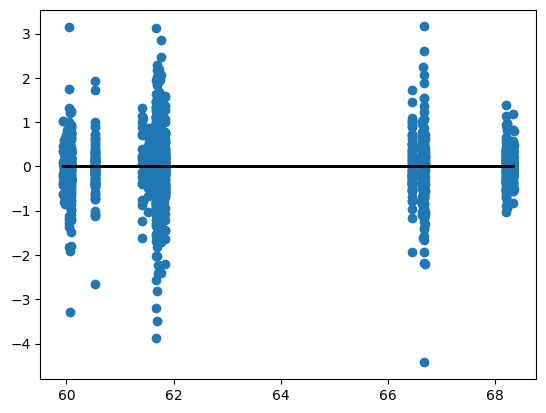

In [91]:
plt.scatter(lat_all, residuals)
plt.plot(lat_all, np.zeros(lat_all.shape), color='k')

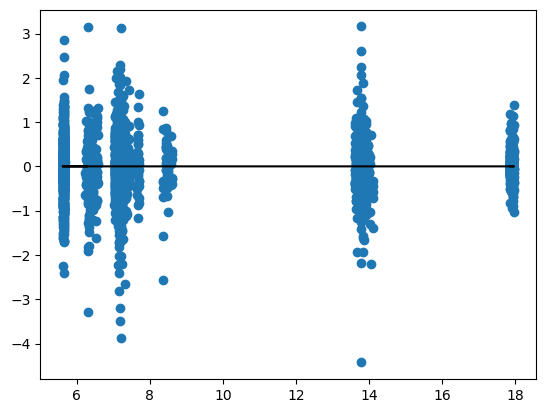

In [92]:
plt.scatter(lon_all, residuals)
plt.plot(lon_all, np.zeros(lon_all.shape), color='k')

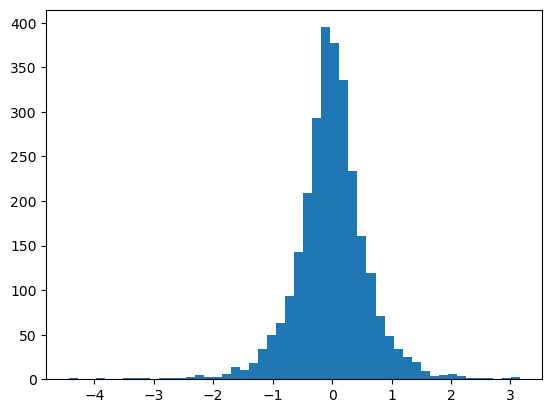

In [102]:
plt.hist(residuals, bins=50);

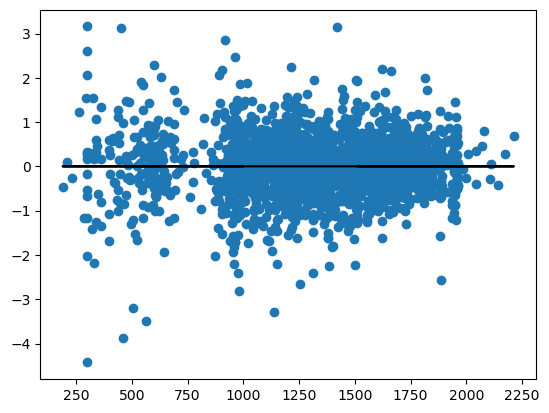

In [107]:
plt.scatter(alt_all, residuals)
plt.plot(alt_all, np.zeros(lon_all.shape), color='k')

## Analyse residuals block-glacier model with annual, summer, winter

In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_14188\3940554349.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2320, 2478, 2769, 3127, 3141]

df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3127 has 145 points
# 3141 has 72 points
# Test dataset has 926 points in total, approximately 24% of the data
# Train dataset has 2984 points, approximately 76% of the data

df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

In [4]:
# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6

C:\Users\kasj\AppData\Local\Temp\ipykernel_14188\1628288660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_14188\1628288660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_14188\1628288660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [5]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, dewpt_temp, surface_pressure, sol_rad_down, sol_therm_down] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

In [6]:
# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)

var = ['u10', 'v10', 't2m', 'fal', 'sshf', 'slhf', 'ssr', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan
        
    

In [7]:
# Combine the three dataframes
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])


In [8]:
# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [9]:
# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [12]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [13]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_minimal_climate_700_trees.pkl')
cv_grid = joblib.load('Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_minimal_climate_700_trees.pkl')

In [14]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [16]:
residuals = get_model_residuals(X_train_s, y_train_s, fitted_model, splits_s)

In [18]:
residuals.shape

(8912,)

In [129]:
y_pred_list = []
y_test_list = []
i=0

for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    #y_resid = residuals[test_index]
    fitted_model.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    #title = 'Validation'

    indices = np.argwhere((X_test == 12))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    y_test_list.extend(y_test_crop)
    y_pred_list.extend(y_pred_crop)
    
    #resid_list.extend(resids)
    
    i=i+1

# Arrays of predictions and observations for each fold
y_test_all = np.hstack([*y_test_list])
y_pred_all = np.hstack([*y_pred_list])
residuals_cropped = y_test_all - y_pred_all

#plot_prediction(y_test_all, y_pred_all, title, n_toplot=5000, fold=False)

#fig.show()

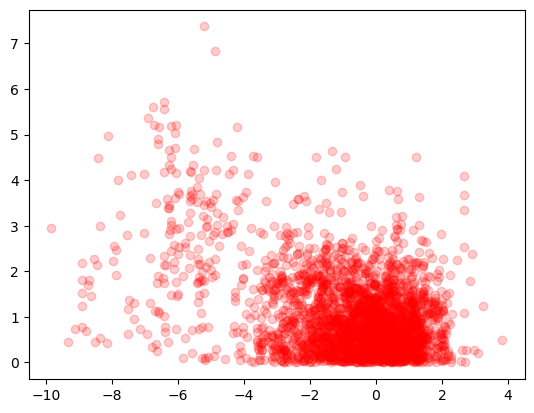

In [137]:
plt.scatter(y_pred_all, abs(residuals_cropped), color='red', alpha=0.2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


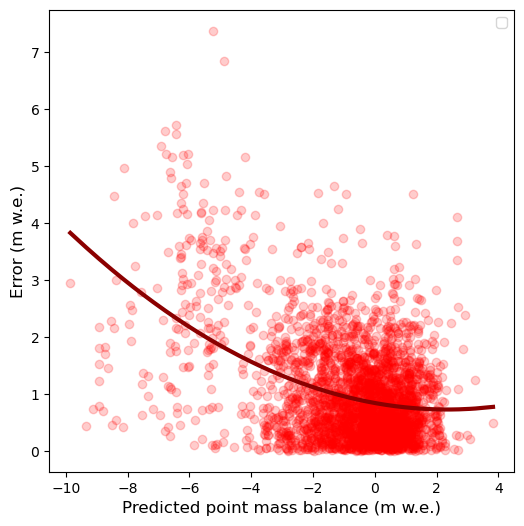

In [147]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y_pred_all, abs(residuals_cropped), color='red', alpha=0.2)

def fit(ax, x,y, sort=True):
    z = np.polyfit(x, y, 2)
    fit = np.poly1d(z)
    if sort:
        x = np.sort(x)
    ax.plot(x, fit(x), color="darkred", alpha=1, lw=3  )  
    ax.legend()

fit(ax, y_pred_all, abs(residuals_cropped), sort=True) 

ax.set_xlabel('Predicted point mass balance (m w.e.)', fontsize=12)
ax.set_ylabel('Error (m w.e.)', fontsize=12)

plt.show()

(-2.0, 2.0)

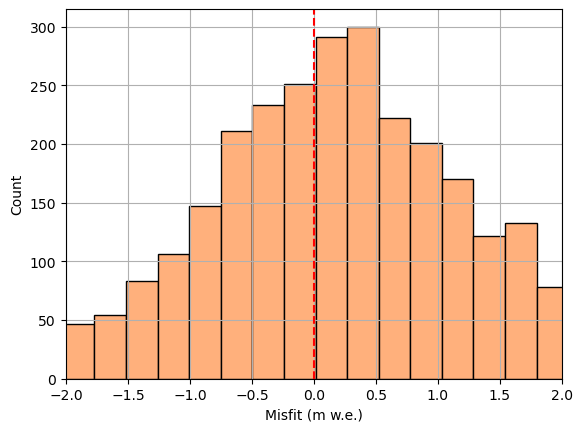

In [152]:
plt.hist(residuals_cropped, bins=51, edgecolor="k", color="#ffb07c"); # bins=50 with all annual mb data
plt.axvline(0.0, ls='--', c='red')
plt.grid()
plt.ylabel('Count')
plt.xlabel('Misfit (m w.e.)')
plt.xlim([-2,2])


In [79]:
resid_all.shape

(2984,)

In [148]:
lon_list = []
lat_list = []
alt_list = []

for train_index, val_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train_ign, X_val = X_train_s[train_index], X_train_s[val_index]
    #X_train_ign, X_val_alt = X_train[train_index], X_train[val_index]
    #X_train_ign, X_val_lon = X_train[train_index], X_train[val_index]

    indices = np.argwhere((X_val == 12))[:,0]

    X_lat = X_val[:,4]
    X_lon = X_val[:,5]
    X_alt = X_val[:,0]

    X_lat = X_lat[indices]
    X_lon = X_lon[indices]
    X_alt = X_alt[indices]
    
    lat_list.extend(X_lat)
    lon_list.extend(X_lon)
    alt_list.extend(X_alt)
        
# Arrays of predictions and observations for each fold
lat_all = np.hstack([*lat_list])
lon_all = np.hstack([*lon_list])
alt_all = np.hstack([*alt_list])

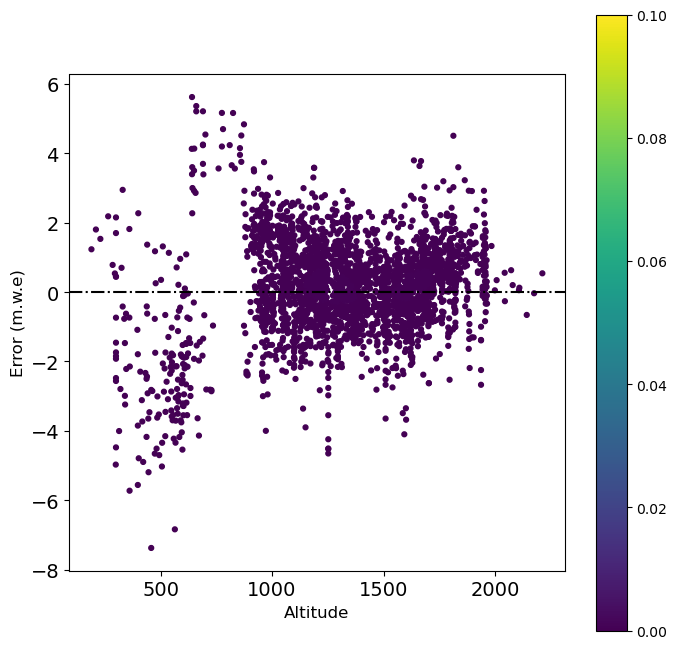

In [151]:
from scipy.stats import gaussian_kde

xy = np.vstack([alt_all, residuals_cropped])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
y_plt, ann_plt, z = alt_all[idx], residuals_cropped[idx], z[idx]

figsize=(8,8)
fontsize=12

fig = plt.figure(figsize=figsize)
#plt.title("Model Evaluation " + data_type, fontsize=fontsize)
plt.ylabel('Error (m.w.e)', fontsize=fontsize)
plt.xlabel('Altitude', fontsize=fontsize)
sc = plt.scatter(y_plt, ann_plt, c=z, s=12)
plt.clim(0,0.1)
plt.tick_params(labelsize=14)
plt.colorbar(sc) 
#plt.axvline(0.0, ls='-.', c='k')
plt.axhline(0.0, ls='-.', c='k')
#plt.xlim(lineStart, lineEnd)
#    plt.ylim(lineStart, lineEnd)
plt.gca().set_box_aspect(1)

#plt.scatter(alt_all, resid_all)
#plt.plot(alt_all, np.zeros(alt_all.shape), color='k')

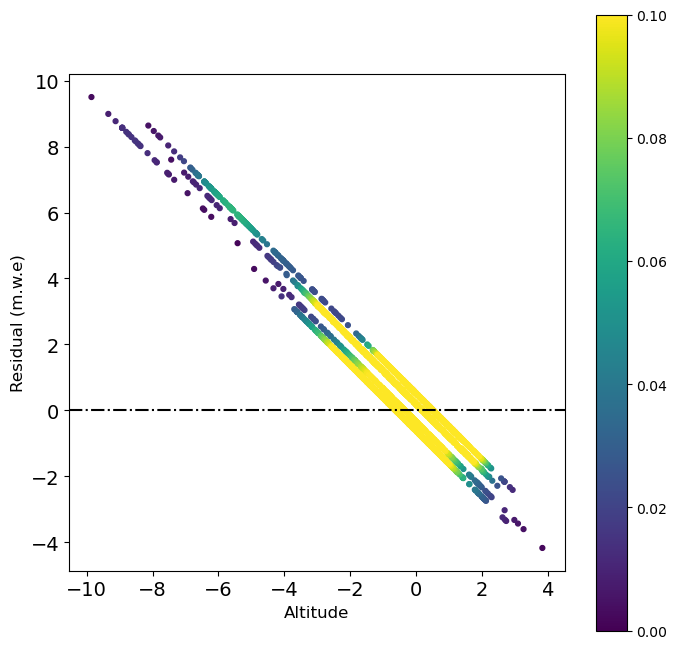

In [108]:
from scipy.stats import gaussian_kde

xy = np.vstack([y_pred_all, resid_all])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
y_plt, ann_plt, z = y_pred_all[idx], resid_all[idx], z[idx]

figsize=(8,8)
fontsize=12

fig = plt.figure(figsize=figsize)
#plt.title("Model Evaluation " + data_type, fontsize=fontsize)
plt.ylabel('Residual (m.w.e)', fontsize=fontsize)
plt.xlabel('Altitude', fontsize=fontsize)
sc = plt.scatter(y_plt, ann_plt, c=z, s=12)
plt.clim(0,0.1)
plt.tick_params(labelsize=14)
plt.colorbar(sc) 
#plt.axvline(0.0, ls='-.', c='k')
plt.axhline(0.0, ls='-.', c='k')
#plt.xlim(lineStart, lineEnd)
#    plt.ylim(lineStart, lineEnd)
plt.gca().set_box_aspect(1)

#plt.scatter(alt_all, resid_all)
#plt.plot(alt_all, np.zeros(alt_all.shape), color='k')